In [200]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from tqdm.notebook import tqdm
import networkx as nx
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

In [204]:
def plot_silhoulette_clusters(ndf,labels,k):
    plt.figure(figsize = (12,6))

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    plt.xlim([-0.1, 1])
    # The (k+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(ndf) + (k + 1) * 10])
    
    silhouette_avg = silhouette_score(ndf, labels)
    sample_silhouette_values = silhouette_samples(ndf, labels)

    y_lower = 10
    bar_colors = []
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.cividis(float(i) / k)
        bar_colors.append(color)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters. Avg Sil = " + '{:.4f}'.format(silhouette_avg))
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

In [387]:
def single_silhouette_score_5(ndf,labels_k):
    
    sample_silhouette_values = silhouette_samples(ndf, labels_k)
    sample_values_k0=[]
    sample_values_k1=[]
    sample_values_k2=[]
    sample_values_k3=[]
    sample_values_k4=[]


    for i in range(0,len(sample_silhouette_values)):
        if labels_k[i]==0:
            sample_values_k0.append(sample_silhouette_values[i])
        elif labels_k[i]==1:
            sample_values_k1.append(sample_silhouette_values[i])
        elif labels_k[i]==2:
            sample_values_k2.append(sample_silhouette_values[i])
        elif labels_k[i]==3:
            sample_values_k3.append(sample_silhouette_values[i])
        else:
            sample_values_k4.append(sample_silhouette_values[i])
            
    print(np.mean(sample_values_k0))
    print(np.mean(sample_values_k1))
    print(np.mean(sample_values_k2))
    print(np.mean(sample_values_k3))
    print(np.mean(sample_values_k4))

In [2]:
df_09=pd.read_csv('../dataset/new_Basket_3_2009.csv', sep=',', index_col=0)
df_10 =pd.read_csv('../dataset/new_Basket_3_2010.csv', sep=',', index_col=0)
df_11=pd.read_csv('../dataset/new_Basket_3_2011.csv', sep=',', index_col=0)
basket=pd.concat([df_09,df_10,df_11])

In [6]:
cust_items=basket.groupby(["Customer ID","StockCode"],as_index=False).size()
cust_items.columns=["Customer ID","StockCode","Count"]
cust_items=cust_items[["Customer ID","StockCode"]]

In [7]:
G = nx.Graph()
G.add_nodes_from(cust_items["Customer ID"])
G.add_nodes_from(cust_items.StockCode)
G.add_edges_from(cust_items.values)

In [9]:
node_list = list(G.nodes()) #returns a list of nodes with index mapping with the a 
num_nodes=len(node_list)
edges=G.edges()
A = nx.to_numpy_array(G)

In [11]:
from sklearn.metrics import pairwise_distances
A = np.exp(- 1./(2 * 1) * pairwise_distances(A, metric='sqeuclidean'))

In [13]:
# Construct diagonal matrix D

D = np.diag(np.sum(A, axis=1))

# Construct the matrix L normalized laplacian
D_ = np.linalg.inv(np.sqrt(D))
L = np.dot(np.dot(D_, A), D_)

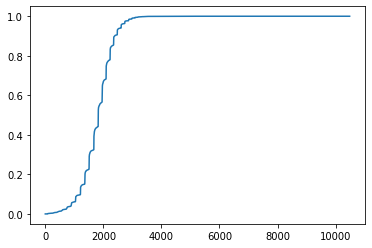

In [16]:
# Extract the eignevalues (ascending order) and normalized (unit “length”) eigenvectors of L
import scipy
w, v = scipy.linalg.eigh(L)
plt.plot(w)
plt.show()

In [330]:
zero_eigenvals_index = np.argwhere(abs(w) >(1+1e-14))
k=zero_eigenvals_index
zero_eigenvals_index

array([[10471],
       [10472],
       [10473],
       [10474],
       [10475],
       [10476],
       [10477],
       [10478],
       [10479],
       [10480],
       [10481],
       [10482],
       [10483],
       [10484]], dtype=int64)

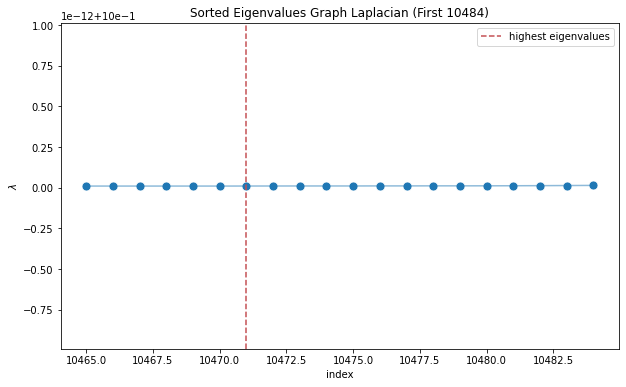

In [531]:
eigenvals_sorted_indices = np.argsort(w)
eigenvals_sorted = w[eigenvals_sorted_indices]
sns_c = sns.color_palette(palette='deep')
index_lim = 10484
index_inf=10465

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=range(index_inf, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[index_inf: index_lim+1], s=80, ax=ax)
sns.lineplot(x=range(index_inf, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[index_inf: index_lim+1], alpha=0.5, ax=ax)
ax.axvline(x=10471, color=sns_c[3], label='highest eigenvalues', linestyle='--')
ax.legend()
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel='index', ylabel=r'$\lambda$');

In [339]:
# Extract k largest eigenvectors
X = v[:, num_nodes - len(k):]

In [340]:
# Construct matrix Y by renormalizing X
Y = np.divide(X, np.reshape(np.linalg.norm(X, axis=1), (X.shape[0], 1)))

In [341]:
proj_df_N = pd.DataFrame(v[:, zero_eigenvals_index.squeeze()])
proj_df_N.columns = ['v_' + str(c) for c in proj_df_N.columns]

In [342]:
kmeans_N = KMeans(n_clusters=len(k),random_state=50).fit(proj_df_N)

In [422]:
df_GN =nx.to_pandas_adjacency(G, dtype=int)
df_GN['cluster'] = kmeans_N.labels_

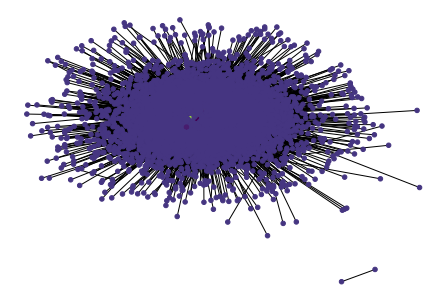

In [351]:
nx.draw(G, node_size=20, pos=nx.spring_layout(G, k=5/math.sqrt(G.order()), iterations=50,scale=25), node_color=kmeans_N.labels_)

In [346]:
for a in range(0,14):
    count=0
    for l in kmeans_N.labels_:
        if l==a:
            count+=1
            
    print(count)
    

630
592
8091
2
1
2
2
2
1
536
2
621
2
1


In [352]:
df_GN=df_GN.iloc[:len(customers),len(customers):]

In [353]:
df_GN=df_GN[(df_GN['cluster']==0) | (df_GN['cluster']==1) | (df_GN['cluster']==2) | (df_GN['cluster']==9) | (df_GN['cluster']==11)]

In [360]:
print(len(df_GN[(df_GN['cluster']==0)]))
print(len(df_GN[(df_GN['cluster']==1)]))
print(len(df_GN[(df_GN['cluster']==2)]))
print(len(df_GN[(df_GN['cluster']==9)]))
print(len(df_GN[(df_GN['cluster']==11)]))

368
368
4429
327
368


In [450]:
c_0=df_GN[df_GN['cluster']==0]
tot_0=[]
prod_0=[]
for c in c_0.columns:
    tot=c_0[c].sum()
    if tot>0:
        prod_0.append(c)
    tot_0.append(tot)
    
item_0=pd.DataFrame({"StockCode":prod_0})

In [457]:
item_0

,StockCode
0,15056BL
1,15056N
2,15056P
3,20679
4,20682
...,...
4125,21225
4126,35945
4127,84311
4128,85043


In [451]:
c_1=df_GN[df_GN['cluster']==1]
tot_1=[]
prod_1=[]
for c in c_1.columns:
    tot=c_1[c].sum()
    if tot>0:
        prod_1.append(c)
    tot_1.append(tot)
    
item_1=pd.DataFrame({"StockCode":prod_1})

In [458]:
item_1

,StockCode
0,15056BL
1,15056N
2,15056P
3,20679
4,20682
...,...
4138,79157B
4139,71434B
4140,21475
4141,85192S


In [452]:
c_2=df_GN[df_GN['cluster']==2]
tot_2=[]
prod_2=[]
for c in c_2.columns:
    tot=c_2[c].sum()
    if tot>0:
        prod_2.append(c)
    tot_2.append(tot)
    
item_2=pd.DataFrame({"StockCode":prod_2})

In [459]:
item_2

,StockCode
0,15056BL
1,15056N
2,15056P
3,20679
4,20682
...,...
4457,23664
4458,15059A
4459,22790
4460,48175


In [453]:
c_9=df_GN[df_GN['cluster']==9]
tot_9=[]
prod_9=[]
for c in c_9.columns:
    tot=c_9[c].sum()
    if tot>0:
        prod_9.append(c)
    tot_9.append(tot)
    
item_9=pd.DataFrame({"StockCode":prod_9})

In [456]:
item_9

,StockCode
0,15056BL
1,15056N
2,15056P
3,20679
4,20682
...,...
4033,18098A
4034,20858
4035,85232C
4036,90004A


In [454]:
c_11=df_GN[df_GN['cluster']==11]
tot_11=[]
prod_11=[]
for c in c_11.columns:
    tot=c_11[c].sum()
    if tot>0:
        prod_11.append(c)
    tot_11.append(tot)
    
item_11=pd.DataFrame({"StockCode":prod_11})

In [455]:
item_11

,StockCode
0,15056BL
1,15056N
2,15056P
3,20679
4,20682
...,...
4259,84966C
4260,62097A
4261,20822
4262,16243B


In [460]:
match=pd.merge(item_0,item_1,on="StockCode")
match

,StockCode
0,15056BL
1,15056N
2,15056P
3,20679
4,20682
...,...
3889,20820
3890,21097
3891,35650
3892,20833


In [449]:
df_GN = pd.read_csv('../dataset/customer/Segmented_Customer_Item_new.csv', sep=',', index_col=0)

In [405]:
df_GN.loc[df_GN['cluster']==9,['cluster']]=3
df_GN.loc[df_GN['cluster']==11,['cluster']]=4

In [407]:
labels_GN=df_GN['cluster']

In [408]:
df_GN.drop(columns=['cluster'])

,15056BL,15056N,15056P,20679,20682,20685,21523,21524,21955,22365,...,20822,21036,21585,85024A,84648,23664,15059A,22790,48175,16243B
12346.0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
12347.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12349.0,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
12350.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18284.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18285.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18286.0,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


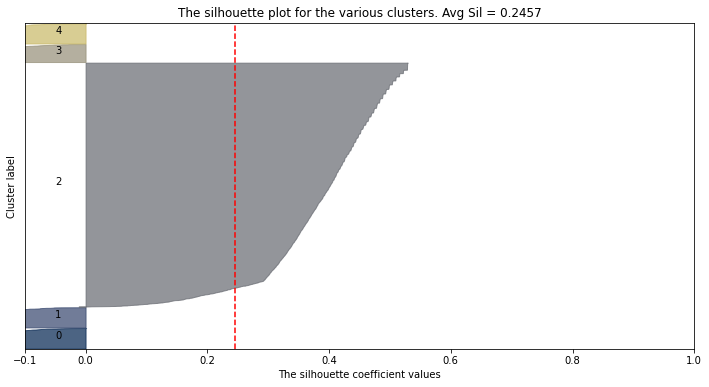

In [409]:
plot_silhoulette_clusters(df_GN,labels_GN,5)

In [412]:
single_silhouette_score_5(df_GN,labels_GN.values)

-0.19557372739264345
-0.20254224643998694
0.3892700318334341
-0.19949462466522705
-0.19665187295842843


In [470]:
cust_ID=18283.0
items_ID=c_0.loc[cust_ID]
list_ID=[]
cont=0
for i in items_ID:
    if i==0:
        list_ID.append(c_0.columns[cont])
        
    cont+=1

In [508]:
freq=[]
for l in list_ID:
    tot=c_0[l].sum()
    freq.append(tot)
    
recc=pd.DataFrame({"StockCode":list_ID,"Freq":freq}).sort_values(by=['Freq'], ascending=False,)[:5]

In [506]:
desc_match=pd.merge(recc,basket,on="StockCode")[["StockCode","Description","Freq"]]

In [512]:
d=desc_match.groupby(["StockCode","Description","Freq"]).count().reset_index().sort_values(by=['Freq'], ascending=False,)
d

,StockCode,Description,Freq
1,22423,REGENCY CAKESTAND 3 TIER,156
0,22138,BAKING SET 9 PIECE RETROSPOT,138
4,84879,ASSORTED COLOUR BIRD ORNAMENT,138
2,22470,HEART OF WICKER LARGE,115
3,47566,PARTY BUNTING,108


In [121]:
df_G.to_csv(r'C:\Users\Stefano\Desktop\Data-Mining-Project\dataset\customer\Segmented_Customer_Item.csv',header=True)

In [378]:
df_GN.to_csv(r'C:\Users\Stefano\Desktop\Data-Mining-Project\dataset\customer\Segmented_Customer_Item_new.csv',header=True)

In [441]:
df_A.to_csv(r'C:\Users\Stefano\Desktop\Data-Mining-Project\dataset\customer\Segmented_Customer_Item_A.csv',header=True)